# Assignment 1
02689 Advanced Numerical Methods for Differential Equations
- Jeppe Klitgaard <`s250250@dtu.dk`>
- Tymoteusz Barcinski <`s221937@dtu.dk`>
- Pernille Christie <`s204249@dtu.dk`>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy
import seaborn as sns
from scipy.special import factorial, gamma
from scipy import stats
from scipy.integrate import quad
from time import perf_counter as time
from tqdm import tqdm

sns.set_theme(style="whitegrid")

## 1 Fourier Methods
### a - Truncated Fourier Expansion

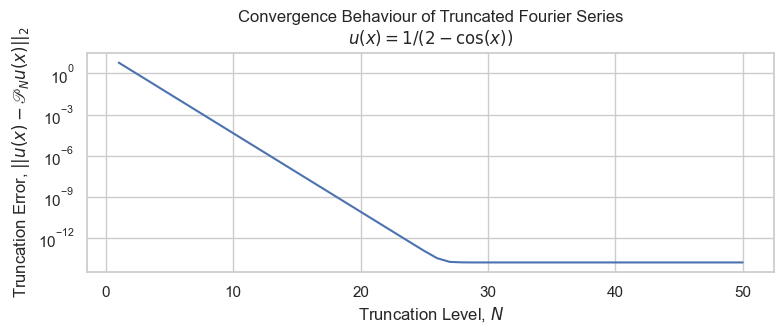

In [2]:
def C_n(n):
    quot = np.sqrt(3) * (2 + np.sqrt(3)) ** np.abs(n)
    return 1 / quot


def u(x):
    return 1.0 / (2.0 - np.cos(x))


x = np.linspace(0, 2 * np.pi, 10000)
y_exact = u(x)

Ns = np.arange(1, 51)
errors = []

for N in Ns:
    y_trunc = np.zeros_like(x, dtype="complex")
    for n in range(-N, N + 1):
        y_trunc += C_n(n) * np.exp(1j * n * x)

    residual = y_exact - y_trunc
    errors.append(np.linalg.norm(residual))

plt.figure(figsize=(8, 3.5))
plt.title(
    "Convergence Behaviour of Truncated Fourier Series\n$u(x) = 1 / (2 - \\cos(x))$"
)
plt.xlabel("Truncation Level, $N$")
plt.ylabel("Truncation Error, $||u(x) - 𝒫︀_N u(x)||_2$")
plt.semilogy(Ns, errors)
plt.grid(True, which="minor", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("report/output/1a_fourier_truncation_convergence.png", dpi=600)


### b - Convergence Behaviour of Discrete Fourier Coefficients

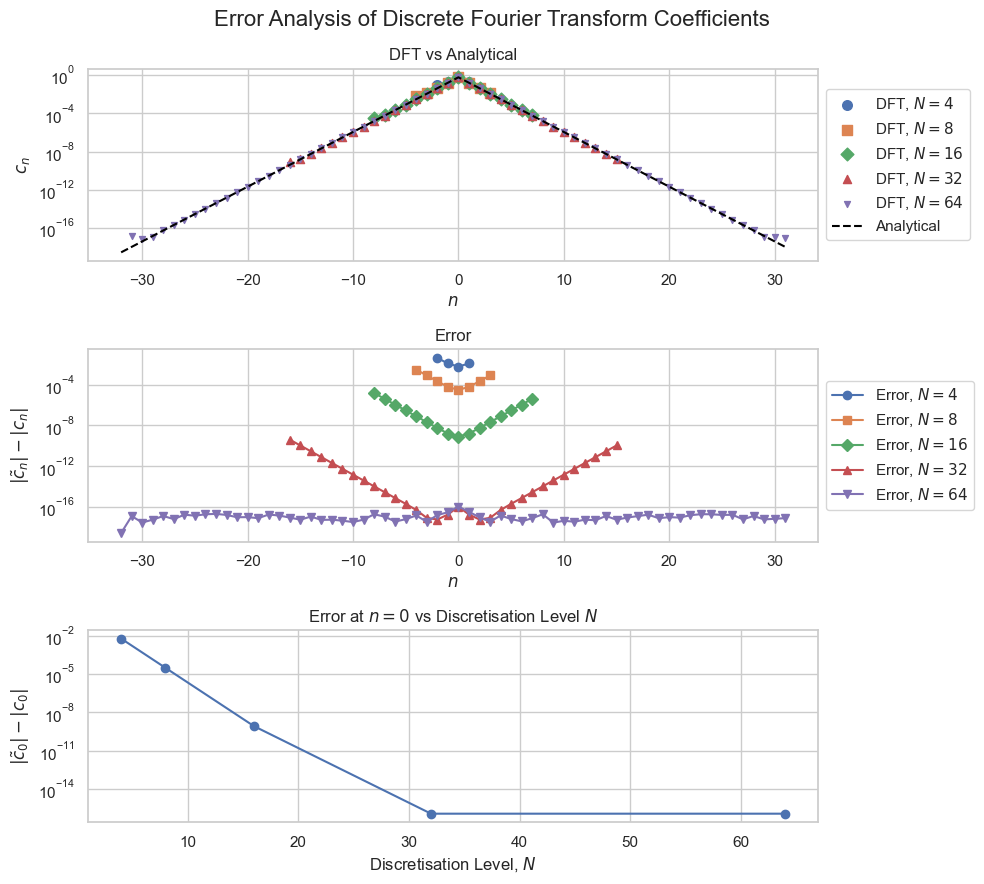

In [3]:
Ns = [4, 8, 16, 32, 64]
x = np.linspace(0, 2 * np.pi, 100)


# Redefine functions to ensure they are not overridden by other u
def C_n(n):
    quot = np.sqrt(3) * (2 + np.sqrt(3)) ** np.abs(n)
    return 1 / quot


def u(x):
    return 1.0 / (2.0 - np.cos(x))


convergence_data = []
for idx, N in enumerate(Ns):
    x_n = np.linspace(0, 2 * np.pi, N, endpoint=False)
    y_n = u(x_n)
    n_range = np.arange(-N // 2, N // 2)

    dft_components = np.fft.fftshift(np.fft.fft(y_n, norm="forward"))
    Cn_components = list(map(C_n, n_range))

    errors = np.abs(dft_components - Cn_components)

    n0_index = np.argmax(n_range == 0)
    error_n0 = errors[n0_index]

    convergence_data.append(
        {
            "N": N,
            "n_range": n_range,
            "dft_magnitudes": np.abs(dft_components),
            "analytical_magnitudes": np.abs(Cn_components),
            "errors": errors,
            "error_n0": error_n0,
        }
    )

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
ax1, ax2, ax3 = axes
markers = ["o", "s", "D", "^", "v"]

# Plot 1: DFT vs Analytical
for datum, marker in zip(convergence_data, markers):
    ax1.scatter(
        datum["n_range"],
        datum["dft_magnitudes"],
        marker=marker,
        label=f"DFT, $N={datum['N']}$",
        s=50 - datum["N"] / 2,
    )

# Plot analytical
ax1.plot(n_range, np.abs(Cn_components), label="Analytical", color="black", ls="--")

ax1.set_title("DFT vs Analytical")
ax1.set_xlabel("$n$")
ax1.set_ylabel("$c_n$")
ax1.semilogy()
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot 2: Error
for datum, marker in zip(convergence_data, markers):
    ax2.plot(
        datum["n_range"],
        datum["errors"],
        label=f"Error, $N={datum['N']}$",
        marker=marker,
        ms=6,
    )
ax2.set_title("Error")
ax2.set_xlabel("$n$")
ax2.set_ylabel(r"$|\tilde{c}_n| - |c_n|$")
ax2.semilogy()
ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot 3: Error at n=0 vs N
N_values = [datum["N"] for datum in convergence_data]
error_n0_values = [datum["error_n0"] for datum in convergence_data]
ax3.plot(N_values, error_n0_values, marker="o")
ax3.set_title("Error at $n=0$ vs Discretisation Level $N$")
ax3.set_xlabel("Discretisation Level, $N$")
ax3.set_ylabel("$|\\tilde{c}_0| - |c_0|$")
ax3.semilogy()

plt.suptitle("Error Analysis of Discrete Fourier Transform Coefficients", fontsize=16)
plt.tight_layout()
plt.savefig(
    "report/output/1b_fourier_dft_error_analysis.png", dpi=600, bbox_inches="tight"
)
plt.show()

### c - Nodal Expansion

C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\3771989630.py:12: RuntimeWarning: invalid value encountered in divide
  1
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\3771989630.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


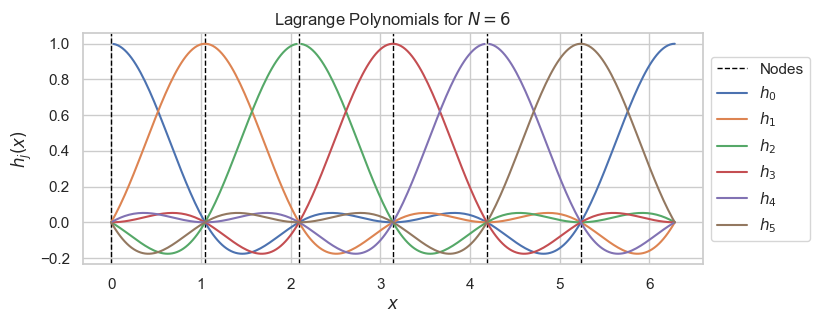

In [4]:
N = 6

fig, ax = plt.subplots(1, figsize=(8, 3))

xjs = 2 * np.pi * np.arange(N) / N
x = np.linspace(0, 2 * np.pi, 250)

for j in range(N):
    xj = xjs[j]

    hjs = (
        1
        / N
        * np.sin(N / 2 * (x - xj))
        * np.cos(1 / 2 * (x - xj))
        / np.sin(1 / 2 * (x - xj))
    )

    for i in range(N):
        if j == 0:
            ax.axvline(x=xjs[i], color="black", ls="--", lw=1, label="Nodes" if i == 0 else None)

    ax.plot(x, hjs, label=f"$h_{j}$")


ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_xlabel("$x$")
ax.set_ylabel("$h_j(x)$")
ax.set_title(f"Lagrange Polynomials for $N={N}$")
fig.show()
fig.savefig("report/output/1c_lagrange_polynomials.png", dpi=600, bbox_inches="tight")

### d - Fourier Differentiation Routine

In [5]:
def h_jk(k, j, N_input):
    diff = k - j
    return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)

def get_D(N_input, index_array = None):
    if index_array is None:
        index_array = np.arange(N_input)
    D_deriv = h_jk(k = index_array[:, None], j = index_array[None, :], N_input = N_input)
    np.fill_diagonal(D_deriv, 0.0)
    return D_deriv

def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

N_max = 50
N_grid = np.arange(2, N_max, step = 4)
# N_grid = np.logspace(1, 2.2, num = 50, dtype = int)
N_grid += N_grid % 2

result = np.zeros(shape = N_grid.shape[0])
for i, N_test in enumerate(N_grid):

    indexes_array = np.arange(N_test)
    x_array = indexes_array * 2*np.pi / N_test
    v_array = v(x_array)
    dv_array = dv(x_array)

    D = h_jk(k = indexes_array[:, None], j = indexes_array[None, :], N_input = N_test)
    np.fill_diagonal(D, 0.0)

    dv_D = D @ v_array

    # result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)
    result[i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)

    # plt.scatter(x_array, dv_array, label = "exact", color = "red")
    # plt.scatter(x_array, dv_D, label = "D @ v_array", marker = "x", color = "green")
    # # plt.title(f"N = {N_text}, error = {result[i]:.2e}")

res = stats.linregress(N_grid[N_grid <= 30], np.log(result)[N_grid <= 30])

C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\2122347786.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)


<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\69594318.py:4: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel("$|| v' - Dv||_{\infty}$ on $x_k = 2k\pi/N$")


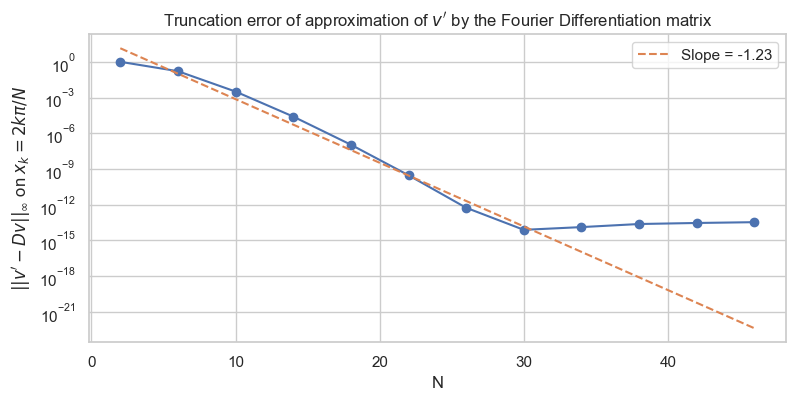

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
ax.semilogy(N_grid, result, marker = "o");
ax.semilogy(N_grid, np.exp(res.intercept + N_grid*res.slope) , linestyle = "--", label = f"Slope = {float(res.slope) :.2f}")
ax.set_ylabel("$|| v' - Dv||_{\infty}$ on $x_k = 2k\pi/N$")
ax.set_xlabel("N")
ax.set_title("Truncation error of approximation of $v'$ by the Fourier Differentiation matrix")
ax.legend(loc = "upper right")
plt.savefig("report/output/1d_convergence_test.png", dpi=600)

### e - Convergence in the $L^2$-norm

In [7]:
def w0(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    return np.cos(x) * np.where(mask, -1.0, 1.0)

def w1(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    return np.sin(x) * np.where(mask, -1.0, 1.0)

def w2(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    base = np.cos(x) - 1.0
    return base * np.where(mask, 1.0, -1.0)

def w3(x):
    x = np.asarray(x)
    mask = (x >= -2*np.pi) & (x <= 0)
    base = np.sin(x) - x
    return base * np.where(mask, 1.0, -1.0)

In [8]:
# general formulas for Lagrange polynomials and their derivatives

def lagrange_poly(x, xj, N, T = 2*np.pi):
    diff = 0.5 * (x - xj) * (2 * np.pi / T)
    return (1 / N) * np.sin(N * diff) / np.tan(diff)

def lagrange_poly_deriv(x, xj, N, T = 2*np.pi):
    diff = (x - xj) * (2 * np.pi / T)
    term1 = 0.5 * np.cos((N / 2) * diff) / np.tan(0.5 * diff)
    term2 = (1 / (2 * N)) * np.sin((N / 2) * diff) / (np.sin(0.5 * diff) ** 2)
    out = (2 * np.pi / T) * (term1 - term2)
    out = np.where(np.isclose(diff, 0.0), 0.0, out)
    return out

def trig_interp_derivative(x_nodes, f_nodes, x_eval, T):
    N = len(x_nodes)
    LJp = lagrange_poly_deriv(x = x_eval[:, None], xj = x_nodes[None, :], N = N, T = T)
    return LJp @ f_nodes

def trig_interp_derivative_FOR_QUADRATURE(x, x_nodes, f_nodes, T):
    N = len(x_nodes)
    LJp = lagrange_poly_deriv(x = x, xj = x_nodes[None, :], N = N, T = T)
    return LJp @ f_nodes


list_functions = [(w1, w0), (w2, w1), (w3, w2)]

x_min, x_max = -2*np.pi, 2*np.pi
T = x_max - x_min

def f_integrate(x, deriv_true, x_nodes, f_nodes, T):
    return (deriv_true(x) - trig_interp_derivative_FOR_QUADRATURE(x, x_nodes, f_nodes, T))**2

N_grid = np.logspace(1, 2.5, num=50, dtype = int)
N_grid += N_grid % 2

results = np.zeros(shape = (len(list_functions), N_grid.shape[0]))

for func_index, (f, fp) in enumerate(list_functions):
    for i, N in enumerate(N_grid):
        x_nodes = np.linspace(x_min, x_max, N, endpoint=False)
        f_nodes = f(x_nodes)

        l2_integral = quad(f_integrate, x_min, x_max, args=(fp, x_nodes, f_nodes, T, ))

        results[func_index, i] = l2_integral[0]

C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\3779790961.py:9: RuntimeWarning: divide by zero encountered in divide
  term1 = 0.5 * np.cos((N / 2) * diff) / np.tan(0.5 * diff)
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\3779790961.py:10: RuntimeWarning: invalid value encountered in divide
  term2 = (1 / (2 * N)) * np.sin((N / 2) * diff) / (np.sin(0.5 * diff) ** 2)
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\3779790961.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  l2_integral = quad(f_integrate, x_min, x_max, args=(fp, x_nodes, f_nodes, T, ))


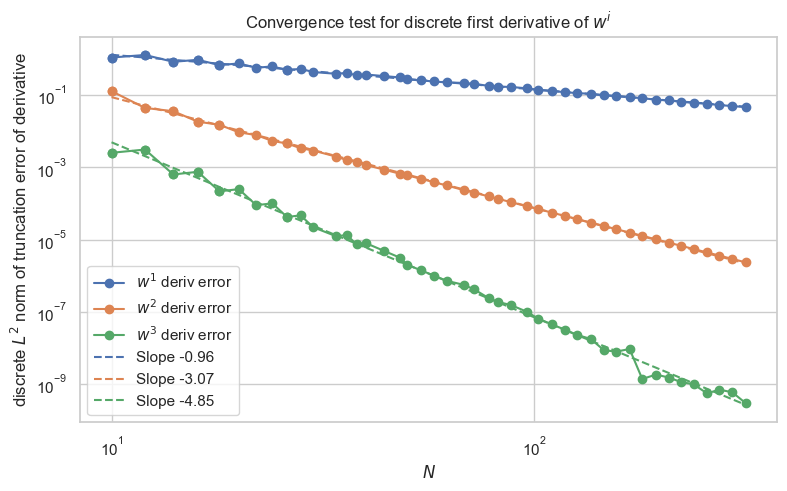

In [9]:
regression_results = np.zeros(shape = (len(list_functions), 2))
for func_index, (f, fp) in enumerate(list_functions):
    res = stats.linregress(np.log(N_grid), np.log(results[func_index, :]))
    regression_results[func_index, 0] = res.intercept
    regression_results[func_index, 1] = res.slope

colors = ["C0", "C1", "C2"]

fig, ax = plt.subplots(1,1, figsize = (9, 5))

ax.loglog(N_grid, results[0, :], marker = "o", label = "$w^1$ deriv error", color = colors[0])
ax.loglog(N_grid, results[1, :], marker = "o", label = "$w^2$ deriv error", color = colors[1])
ax.loglog(N_grid, results[2, :], marker = "o", label = "$w^3$ deriv error", color = colors[2])

ax.loglog(N_grid, np.exp(regression_results[0, 0])*N_grid**regression_results[0, 1], color = colors[0], linestyle = "--", label = f"Slope {regression_results[0, 1]:.2f}")
ax.loglog(N_grid, np.exp(regression_results[1, 0])*N_grid**regression_results[1, 1], color = colors[1], linestyle = "--", label = f"Slope {regression_results[1, 1]:.2f}")
ax.loglog(N_grid, np.exp(regression_results[2, 0])*N_grid**regression_results[2, 1], color = colors[2], linestyle = "--", label = f"Slope {regression_results[2, 1]:.2f}")

ax.set_ylabel("discrete $L^2$ norm of truncation error of derivative")
ax.set_xlabel("$N$")
ax.set_title("Convergence test for discrete first derivative of $w^i$")
ax.legend()
plt.savefig("report/output/1e_convergence_test_wi.png", dpi=600)

### f - Numerical Differentiation using Fast Fourier Transform

In [10]:
def v(x): return np.exp(np.sin(x))
def dv(x): return np.exp(np.sin(x)) * np.cos(x)

N_max = 100
N_grid = np.logspace(1, 4, num=N_max).astype(int)
N_grid += N_grid % 2

K_simulations = 10

result = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))
result_l2 = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))
times = np.zeros(shape = (K_simulations, 2, N_grid.shape[0]))

for k in tqdm(range(K_simulations)):
    for i, N_test in enumerate(N_grid):

        indexes_array = np.arange(N_test)
        x_array = indexes_array * 2*np.pi / N_test
        v_array = v(x_array)
        dv_array = dv(x_array)

        D = get_D(N_input = N_test)
        start = time()
        dv_D = D @ v_array
        times[k, 0, i] = time() - start

        dft_components = np.fft.fft(v_array, n=N_test, norm="forward")
        start = time()
        diffx_FFT = np.fft.ifft(1j * np.fft.fftshift(np.arange(-N_test/2, N_test/2)) * dft_components, norm = "forward")
        times[k, 1, i] = time() - start

        result[k, 0, i] = np.linalg.norm(dv_array - dv_D, ord = np.inf)
        result[k, 1, i] = np.linalg.norm(dv_array - diffx_FFT, ord = np.inf)

        result_l2[k, 0, i] = np.linalg.norm(dv_array - dv_D, ord = 2)
        result_l2[k, 1, i] = np.linalg.norm(dv_array - diffx_FFT, ord = 2)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\2122347786.py:3: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * np.power(-1.0, diff) * np.cos(1/N_input * np.pi * diff) / np.sin(1/N_input * np.pi * diff)
100%|██████████| 10/10 [04:13<00:00, 25.33s/it]


<>:34: SyntaxWarning: invalid escape sequence '\;'
<>:43: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\;'
<>:43: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\2482557992.py:34: SyntaxWarning: invalid escape sequence '\;'
  label = "$O(N\;log(N))$")
C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\2482557992.py:43: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_ylabel("$ \dfrac{1}{N} ||v' - \hat{v'}||_2 $")


beta_D = array([-19.82917731,   1.66227841]), beta_fft = array([-12.95173309,   0.56965253]), coef_fft = np.float64(-14.020791542172061)


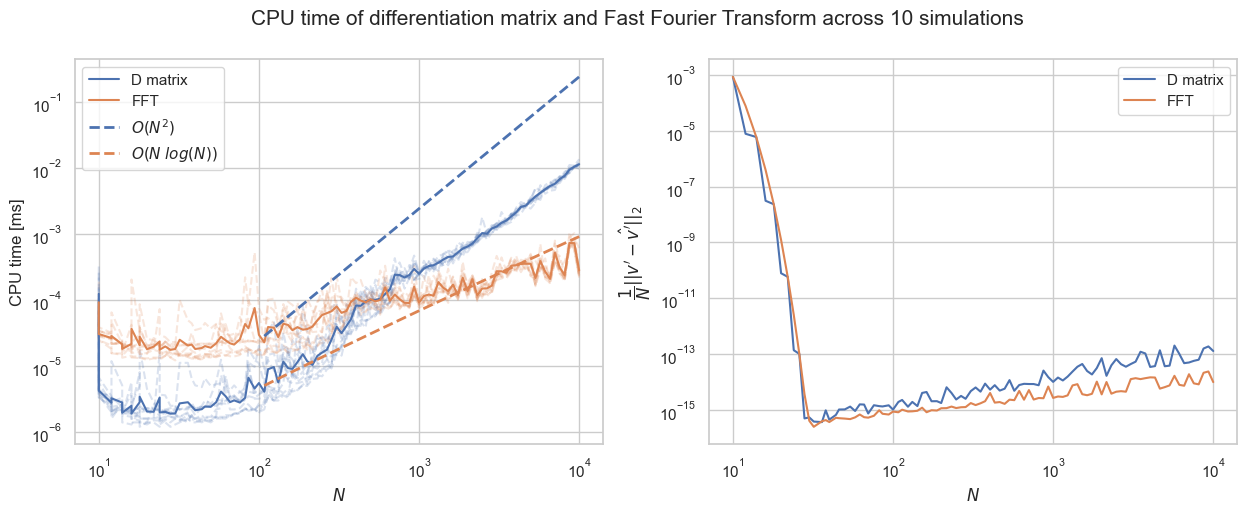

In [31]:
result_l2_scaled = result_l2 / N_grid

result_mean = np.mean(result_l2_scaled, axis = 0)
times_mean = np.mean(times, axis = 0)

def ls(x, y, mask = None):
    x = x[mask]
    y = y[mask]
    A = np.c_[(np.ones(x.shape[0]), x)]
    beta = np.linalg.solve(A.T @ A, A.T @ y)
    return beta

beta_D = ls(np.log(N_grid), np.log(times_mean[0, :]), mask = N_grid > 100)
beta_fft = ls(np.log(N_grid), np.log(times_mean[1, :]), mask = N_grid > 100)

coef_fft = times_mean[1, N_grid > 100] / N_grid[N_grid > 100] * np.log(N_grid[N_grid > 100])
coef_fft = np.mean(np.log(coef_fft))


print(f"{beta_D = }, {beta_fft = }, {coef_fft = }")

alpha = 0.2

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for k in range(K_simulations):
    ax[0].loglog(N_grid, times[k, 0, :], linestyle='--', alpha = alpha, color = "C0");
    ax[0].loglog(N_grid, times[k, 1, :], linestyle='--', alpha = alpha, color = "C1");
ax[0].loglog(N_grid, times_mean[0, :], label = "D matrix", color = "C0");
ax[0].loglog(N_grid, times_mean[1, :], label = "FFT", color = "C1");
ax[0].loglog(N_grid[N_grid > 100], (np.exp(beta_D[0])*N_grid**2)[N_grid > 100], linestyle='--', color = "C0", linewidth=2,
             label = "$O(N^2)$")
ax[0].loglog(N_grid[N_grid > 100], ((1e-8)*N_grid*np.log(N_grid))[N_grid > 100], linestyle='--', color = "C1", linewidth=2,
             label = "$O(N\;log(N))$")
ax[0].set_xlabel("$N$")
ax[0].set_ylabel("CPU time [ms]")
ax[0].legend();

ax[1].loglog(N_grid, result_mean[0, :], label = "D matrix", color = "C0");
ax[1].loglog(N_grid, result_mean[1, :], label = "FFT", color = "C1");
ax[1].legend();
ax[1].set_xlabel("$N$")
ax[1].set_ylabel("$ \dfrac{1}{N} ||v' - \hat{v'}||_2 $")

plt.suptitle("CPU time of differentiation matrix and Fast Fourier Transform across 10 simulations", fontsize=15)
fig.savefig("report/output/1f_FFT_D_CPU_time.png", dpi=600, bbox_inches="tight")

## 2 Polynomial Methods
### h - Jacobi Polynomials

In [12]:
def a(alpha, beta, n1, n2):
    """Calculate a values for given alpha, beta and n
    - last entry must be equal to n-1, n or n+1"""

    if n1 == n2 - 1 and n2 > 0:
        return (2 * (n2 + alpha) * (n2 + beta)) / (
            (2 * n2 + alpha + beta + 1) * (2 * n2 + alpha + beta)
        )
    elif n1 == n2:
        return (alpha**2 - beta**2) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta)
        )
    elif n1 == n2 + 1:
        return (2 * n1 * (n1 + alpha + beta)) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta + 1)
        )
    elif n1 == -1 and n2 == 0:
        return 0
    else:
        raise ValueError("Invalid n1,n2")


def JacobiP(x, alpha, beta, n):
    x = np.asarray(x)

    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 0.5 * (alpha - beta + (alpha + beta + 2) * x)

    # Start values
    Pnm2 = np.ones_like(x)  # P_0
    Pnm1 = 0.5 * (alpha - beta + (alpha + beta + 2) * x)  # P_1

    # Iterate recurrence
    for k in range(2, n + 1):
        num = (a(alpha, beta, k - 1, k - 1) + x) * Pnm1 - a(
            alpha, beta, k - 2, k - 1
        ) * Pnm2
        denom = a(alpha, beta, k, k - 1)
        Pn = num / denom
        Pnm2, Pnm1 = Pnm1, Pn

    return Pnm1

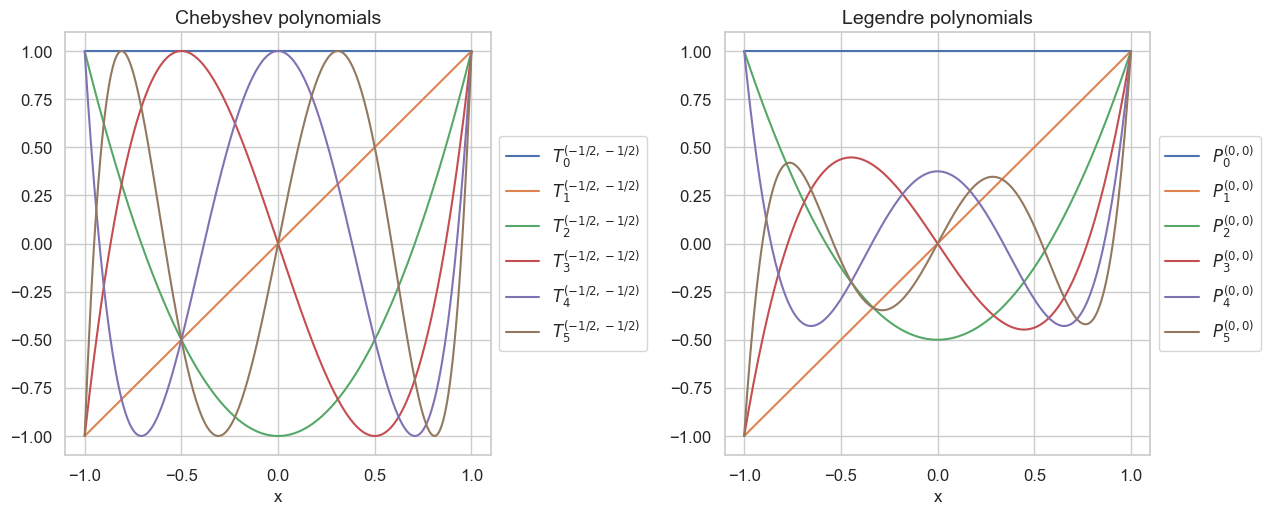

In [13]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))

x = np.linspace(-1, 1, 250)

for n in range(6):
    axs[0].plot(
        x,
        scipy.special.gamma(n + 1)
        * scipy.special.gamma(1 / 2)
        / scipy.special.gamma(n + 1 / 2)
        * JacobiP(x, -1 / 2, -1 / 2, n),
        label=rf"$T_{n}^{{(-1/2, -1/2)}}$",
    )
    axs[1].plot(x, JacobiP(x, 0, 0, n), label=rf"$P_{n}^{{(0,0)}}$")


axs[0].set_title("Chebyshev polynomials", fontsize=14)
axs[1].set_title("Legendre polynomials", fontsize=14)
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)


for ax in axs:
    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel("x", fontsize=12)

plt.subplots_adjust(wspace=0.55)

plt.savefig("report/output/2h_jacobi_polynomials.png", dpi=600, bbox_inches="tight")

### i - Numerical Experiments

In [14]:
def JacobiGQ(alpha, beta, N):
    """Translated code given by APEK"""

    if N == 0:
        x = np.array([-(alpha - beta) / (alpha + beta + 2)])
        w = np.array([2])

        return x, w

    J = np.zeros((N + 1, N + 1), dtype=float)

    # Form symmetric matrix from recurrence.
    h1 = 2 * np.arange(N + 1) + alpha + beta
    J = np.diag(-1 / 2 * (alpha**2 - beta**2) / (h1 + 2) / h1)

    off_diag = (
        2.0
        / (h1[:-1] + 2)
        * np.sqrt(
            (
                np.arange(1, N + 1)
                * (np.arange(1, N + 1) + alpha + beta)
                * (np.arange(1, N + 1) + alpha)
                * (np.arange(1, N + 1) + beta)
            )
            / ((h1[:-1] + 1) * (h1[:-1] + 3))
        )
    )

    J += np.diag(off_diag, 1)

    if alpha + beta < 10 * np.finfo(float).eps:
        J[0, 0] = 0.0

    J = J + J.T

    D, V = np.linalg.eigh(J)  # eigh ensures real symmetric matrix handling
    x = D

    w = (
        (V[0, :] ** 2)
        * 2 ** (alpha + beta + 1)
        / (alpha + beta + 1)
        * scipy.special.gamma(alpha + 1)
        * scipy.special.gamma(beta + 1)
        / scipy.special.gamma(alpha + beta + 1)
    )

    return x, w


def JacobiGL(alpha, beta, N):
    x = np.zeros(N + 1, dtype=float)

    if N == 1:
        x = np.array([-1, 1])

        return x

    xint, _ = JacobiGQ(alpha + 1, beta + 1, N - 2)

    x = np.concatenate((np.array([-1]), xint, np.array([1])))

    return x

In [15]:
def CalculateCoefficients(N, K, u):
    """Calculate all K coefficients for grid of size N, for a function given by u"""

    # Quadrature points
    x = JacobiGL(0, 0, N)
    # Quadrature weights
    w = 2 / (N * (N + 1)) / np.power(JacobiP(x, 0, 0, N), 2)

    u_samples = u(x)

    # Precompute Jacobi polynomials for all k=0..K-1
    # Shape: (K, len(x))
    Phi = np.vstack([JacobiP(x, 0, 0, k) for k in range(K)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((u_samples * Phi) * w, axis=1)

    return numerators / gamma

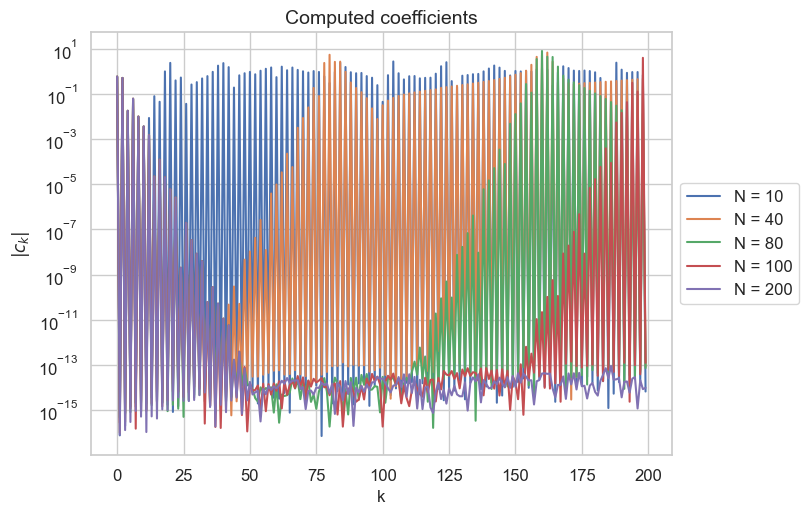

In [16]:
# Calculate all coefficients
K = 200
Ns = [10, 40, 80, 100, 200]


def u(x):
    return 1.0 / (2.0 - np.cos(np.pi * (x + 1)))
    # return np.sin(2*np.pi*(x + 0.1))


coefficients = np.zeros((len(Ns), K), dtype=float)


for i, N in enumerate(Ns):
    coefficients[i, :] = CalculateCoefficients(N, K, u)


# Plot absolte vale of all coefficients
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.5))

for i in range(len(Ns)):
    ax.plot(abs(coefficients[i]), label=f"N = {Ns[i]}")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
ax.set_xlabel("k", fontsize=12)
ax.set_ylabel(r"$|c_k|$", fontsize=12)
ax.set_title("Computed coefficients", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.set_yscale("log")

plt.savefig("report/output/2i_coefficients.png", dpi=600, bbox_inches="tight")

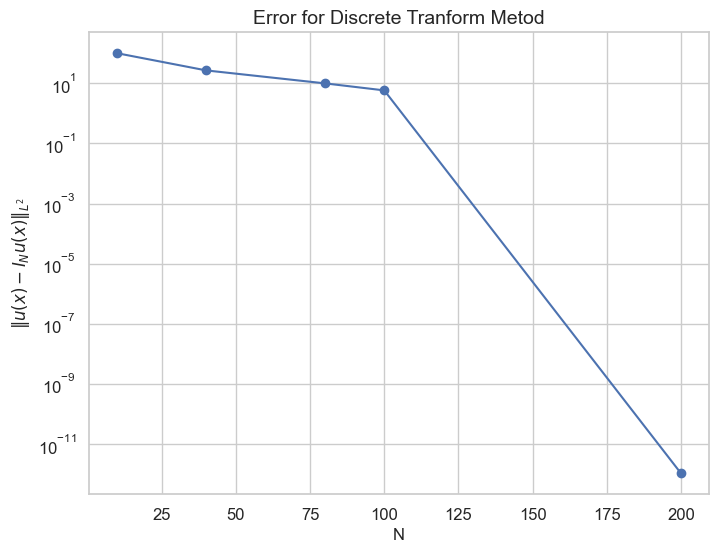

In [17]:
# Plot errors
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

xs = np.linspace(-1, 1, 250)

Phi = np.vstack([JacobiP(xs, 0, 0, k) for k in range(K)])

u_samples = u(xs)

errors = np.zeros_like(Ns, dtype=float)

for i in range(len(Ns)):
    u_approx = coefficients[i] @ Phi

    errors[i] = np.linalg.norm(u_samples - u_approx)


ax.plot(Ns, errors, "-o")
ax.set_xlabel("N", fontsize=12)
ax.set_ylabel(r"$\|u(x) - I_N u(x)\|_{L^2}$", fontsize=12)
ax.set_title("Error for Discrete Tranform Metod", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.set_yscale("log")
plt.savefig("report/output/2i_error_DTM.png", dpi=600)

### j - Generalized Vandermonde Matrix

In [18]:
def VandermondeMatrix(N):
    """Calculate the transposed Vandermonde Matrix for grid of size N"""

    # Calculate abscissus
    xN = JacobiGL(0, 0, N - 1)

    VT = np.zeros((N, N), dtype=float)

    # Calculate the Jacobi polynomials for each column of transposed Vandermonde
    for n in range(N):
        VT[n, :] = JacobiP(xN, 0, 0, n)

    return VT

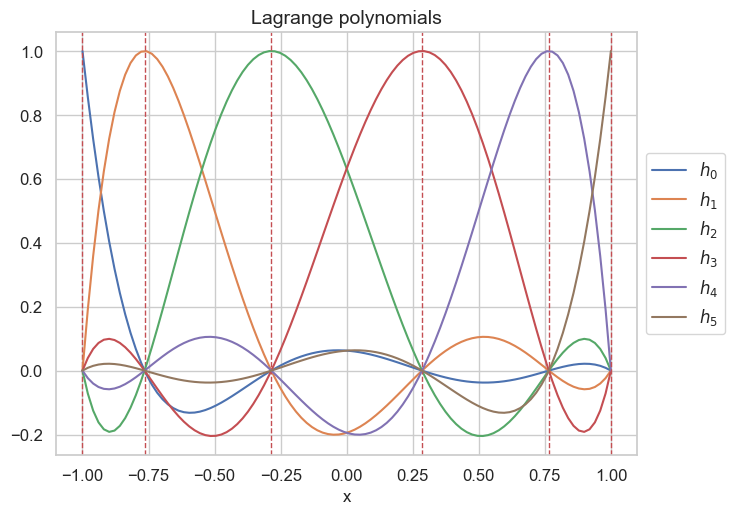

In [19]:
N = 6
nodes = 100

xN = JacobiGL(0, 0, N - 1)

xunif = np.linspace(-1, 1, nodes)

phis = np.zeros((N, nodes), dtype=float)

# Evaluate each jaobi polynomial on the uniform grid
for n in range(N):
    phis[n] = JacobiP(xunif, 0, 0, n)

VT = VandermondeMatrix(N)

hs = np.zeros((N, nodes), dtype=float)

# Solve the equation system for each grid value
for i in range(nodes):
    hs[:, i] = np.linalg.solve(VT, phis[:, i])


# Plot resulting Lagrange polynomials and gridpoints
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.5))
for n in range(N):
    ax.plot(xunif, hs[n], label=rf"$h_{n}$")
    ax.axvline(x=xN[n], color="r", ls="--", lw=1)


ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
ax.set_xlabel("x", fontsize=12)
ax.set_title("Lagrange polynomials", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
plt.savefig("report/output/2k_lagrange_polynomials.png", dpi=600, bbox_inches="tight")

In [20]:
# Calculate approximations of v


def v(x):
    return np.sin(np.pi * x)


Ns = np.arange(1, 50, 5)

v_exact = v(xunif)

errors = np.zeros_like(Ns, dtype=float)

v_approx = np.zeros((len(Ns), nodes), dtype=float)

for j, N in enumerate(Ns):
    # Calculate DPT coefficients v_hat
    K = N + 1

    v_hat = CalculateCoefficients(N, K, v)

    # Calculate Vandermonde matrix
    VT = VandermondeMatrix(N + 1)

    Phi_unif = np.zeros((N + 1, nodes), dtype=float)

    for n in range(N + 1):
        Phi_unif[n] = JacobiP(xunif, 0, 0, n)

    # From DFT coefficients calculate polynomial representation coefficients
    v_lag = VT.T @ v_hat

    # Calculate Lagrange polynomials as before
    hs = np.zeros((N + 1, nodes), dtype=float)

    for i in range(nodes):
        hs[:, i] = np.linalg.solve(VT, Phi_unif[:, i])

    # Calculate error
    v_approx[j] = np.sum(hs * v_lag[:, None], axis=0)
    errors[j] = np.linalg.norm(v_exact - v_approx[j])

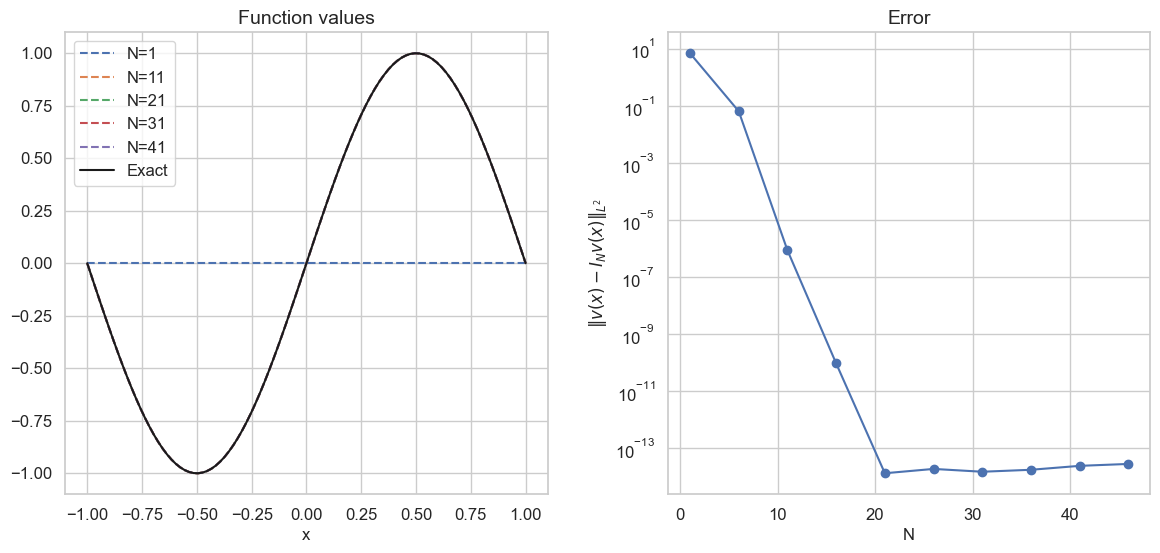

In [21]:
# Plot interpolant vs exact solution and errors
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i in range(0, len(Ns), 2):
    ax[0].plot(xunif, v_approx[i], "--", label=f"N={Ns[i]}")


ax[0].plot(xunif, v_exact, "k", label="Exact")
ax[0].legend(fontsize=12)
ax[0].set_title("Function values", fontsize=14)
ax[0].set_xlabel("x")

ax[1].plot(Ns, errors, "-o")
ax[1].set_title("Error", fontsize=14)
ax[1].set_yscale("log")
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\|v(x) - I_N v(x)\|_{L^2}$", fontsize=12)


for axis in ax:
    axis.tick_params(axis="both", labelsize=12)

plt.subplots_adjust(wspace=0.25)

plt.savefig("report/output/2k_errors.png", dpi=600)

In [22]:
# To extrapolate, we reuse the code, but change the uniform grid
Ns = np.arange(1, 50, 5)

nodes = 150

xunif = np.linspace(-1.5, 1.5, nodes)

v_exact = v(xunif)

errors = np.zeros_like(Ns, dtype=float)

v_approx = np.zeros((len(Ns), nodes), dtype=float)

for j, N in enumerate(Ns):
    # Calculate DPT coefficients v_hat
    K = N + 1

    v_hat = CalculateCoefficients(N, K, v)

    # Calculate Vandermonde matrix
    VT = VandermondeMatrix(N + 1)

    Phi_unif = np.zeros((N + 1, nodes), dtype=float)

    for n in range(N + 1):
        Phi_unif[n] = JacobiP(xunif, 0, 0, n)

    # From DFT coefficients calculate polynomial representation coefficients
    v_lag = VT.T @ v_hat

    # Calculate Lagrange polynomials
    hs = np.zeros((N + 1, nodes), dtype=float)

    for i in range(nodes):
        hs[:, i] = np.linalg.solve(VT, Phi_unif[:, i])

    # Calculate error
    v_approx[j] = np.sum(hs * v_lag[:, None], axis=0)
    errors[j] = np.linalg.norm(v_exact - v_approx[j])

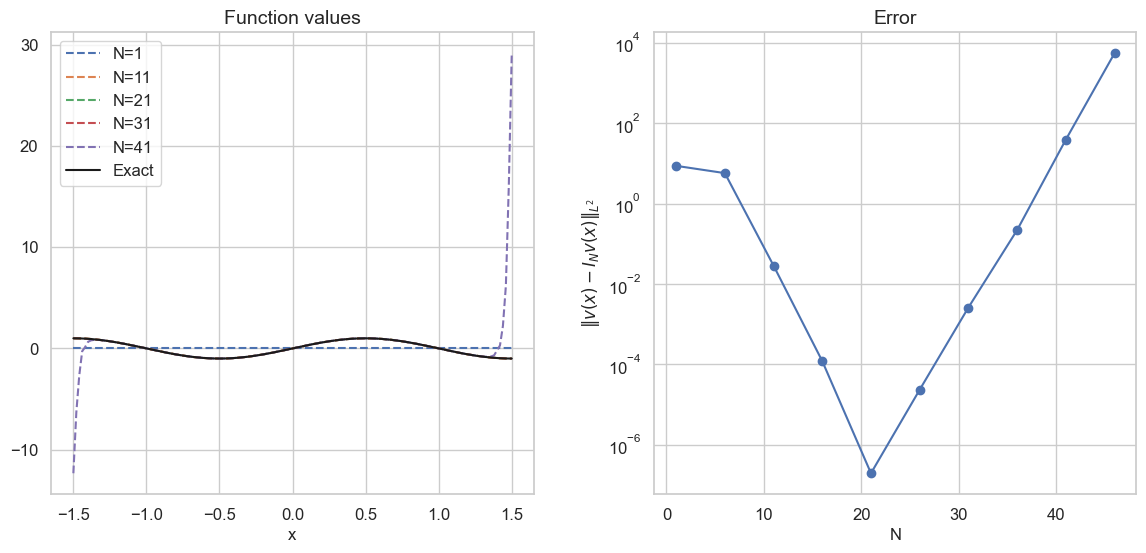

In [23]:
# Plot interpolant vs exact solution and errors
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for i in range(0, len(Ns) - 1, 2):
    ax[0].plot(xunif, v_approx[i], "--", label=f"N={Ns[i]}")


ax[0].plot(xunif, v_exact, "k", label="Exact")
ax[0].legend(fontsize=12)
ax[0].set_title("Function values", fontsize=14)
ax[0].set_xlabel("x")

ax[1].plot(Ns, errors, "-o")
ax[1].set_title("Error", fontsize=14)
ax[1].set_yscale("log")
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\|v(x) - I_N v(x)\|_{L^2}$", fontsize=12)


for axis in ax:
    axis.tick_params(axis="both", labelsize=12)

plt.subplots_adjust(wspace=0.25)

plt.savefig("report/output/2k_errors_extended.png", dpi=600)

### k - Derivative of Jacobi Polynomials

C:\Users\jeppe\AppData\Local\Temp\ipykernel_21924\2570624656.py:153: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


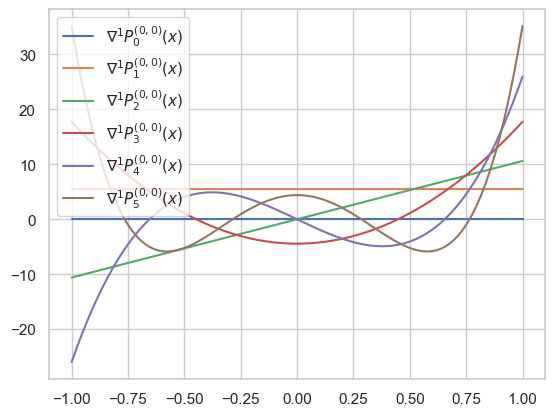

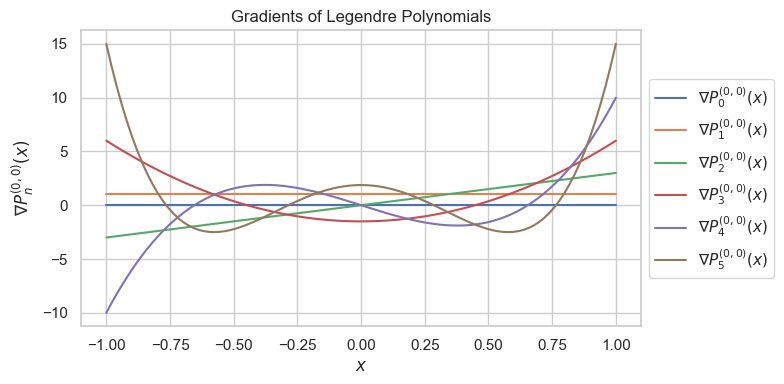

In [24]:
def jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Evaluates first `n+1` Jacobi polynomials at points `x` with parameters `alpha` and `beta`.
    Reflects L2, slide 12.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)

    Returns: Array of shape (m, n+1) where each column corresponds to a Jacobi polynomial
        Note that this is essentially the Vandermonde matrix for Jacobi polynomials.
    """
    assert n >= 0, "n must be non-negative"

    P = np.empty((len(x), n + 1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1 / 2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = (
            2
            * (k + alpha)
            * (k + beta)
            / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        )
        a_n_n = (alpha**2 - beta**2) / (
            (2 * k + alpha + beta + 2) * (2 * k + alpha + beta)
        )
        a_np1_n = (
            2
            * (k + 1)
            * (k + alpha + beta + 1)
            / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))
        )

        P[:, k + 1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k - 1]) / a_np1_n

    return P


def jacobi_p_normalisation_const(
    alpha: float, beta: float, n: int | npt.NDArray
) -> int | npt.NDArray:
    """
    Computes the normalisation constant for Jacobi polynomials.
    Reflects $γ_n^(α,β)$ from L2, slide 11.

    Arguments:
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: npt.ArrayLike

    Returns: normalisation constant(s) $γ$ for Jacobi polynomials $P_n$
    """
    return (
        2 ** (alpha + beta + 1)
        * (gamma(n + alpha + 1) * gamma(n + beta + 1))
        / (factorial(n) * (2 * n + alpha + beta + 1) * gamma(n + alpha + beta + 1))
    )


def jacobi_p_normalised(
    x: npt.NDArray, alpha: float, beta: float, n: int
) -> npt.NDArray:
    """
    Convenience function to get normalized Jacobi polynomials using `jacobi_p` and `jacobi_p_normalisation_const`.
    """
    P = jacobi_p(x, alpha, beta, n)
    norm_const = jacobi_p_normalisation_const(alpha, beta, np.arange(n + 1))
    return P / np.sqrt(norm_const)


def grad_orthonormal_jacobi_p(x, alpha, beta, n, k):
    grad_ortho_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p = np.zeros_like(x)
        elif i == 1:
            p = np.ones_like(x)
        else:
            p = jacobi_p_normalised(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = (
            1
            * gamma(alpha + beta + n + 1 + k)
            / (2**k * gamma(alpha + beta + n + 1))
            * np.sqrt(
                jacobi_p_normalisation_const(alpha + k, beta + k, n - k)
                / jacobi_p_normalisation_const(alpha, beta, n)
            )
        )

        grad_ortho_p[:, i] = coeff * p

    return grad_ortho_p


x = np.linspace(-1, 1, 100)
plt.figure()
alpha, beta = 0, 0
n = 5
k = 1
P_grad = grad_orthonormal_jacobi_p(x, alpha, beta, n, k)
for i, p in enumerate(P_grad.T):
    plt.plot(x, p, label=f"$\\nabla^1 P_{{{i}}}^{{({alpha}, {beta})}}(x)$")
plt.legend()


# Actually we should just need the regular one given the lectures, so this is very easy
def grad_jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Computes the gradient of the first `n+1` Jacobi polynomials at nodes `x`.
    Reflects L2, slide 15.

    Arguments:
        x: Points at which to evaluate the gradients, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)
    Returns: Array of shape (m, n+1) where each column corresponds to the gradient of a Jacobi polynomial
    """
    grad_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p_i = np.zeros_like(x)
        else:
            p_i = jacobi_p(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = 1 / 2 * (alpha + beta + i + 1)
        grad_p[:, i] = coeff * p_i

    return grad_p


plt.figure(figsize=(8, 4), layout="constrained")
P_grad = grad_jacobi_p(x, alpha, beta, n=6)[:, :6]
for i, p in enumerate(P_grad.T):
    plt.plot(x, p, label=f"$\\nabla P_{{{i}}}^{{({alpha}, {beta})}}(x)$")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Gradients of Legendre Polynomials")
plt.xlabel("$x$")
plt.ylabel("$\\nabla P_n^{(0,0)}(x)$")
plt.tight_layout()
plt.savefig(
    "report/output/2k_polynomial_grad_legendre.png", dpi=600, bbox_inches="tight"
)


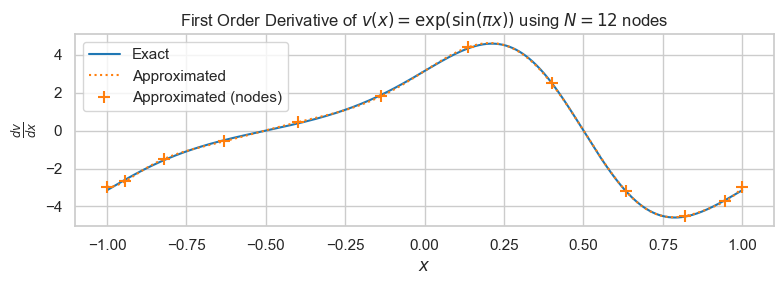

In [25]:
# Redefine just to make sure it is correct function
def v(x):
    return np.exp(np.sin(np.pi * x))

def dv_dx(x):
    return np.pi * v(x) * np.cos(np.pi * x)

alpha = 0.0  # Legendre
beta = 0.0  # Legendre
N_nodes = 12
P_nodes = N_nodes - 1
assert N_nodes > 1

x_nodes = JacobiGL(alpha, beta, P_nodes)
w_nodes = (
    2
    / (N_nodes * (N_nodes + 1))
    * 1
    / ((jacobi_p(x_nodes, alpha, beta, N_nodes) ** 2)[:, N_nodes])
)

# Modal basis functions
V = jacobi_p(x_nodes, alpha, beta, P_nodes)

# Derivatives of modal basis functions at nodes
V_x = grad_jacobi_p(x_nodes, alpha, beta, P_nodes)

diff_matrix = V_x @ np.linalg.inv(V)

# Now get nodes and evaluate
v_nodal = v(x_nodes)

# Evaluate derivative using differentiation matrix
dv_approx_nodal = diff_matrix @ v_nodal
dv_exact_nodal = dv_dx(x_nodes)

x_fine = np.linspace(-1, 1, 1000)
dv_exact_fine = dv_dx(x_fine)
dv_approx_fine = grad_jacobi_p(x_fine, alpha, beta, P_nodes) @ np.linalg.solve(
    V, v_nodal
)


plt.figure(figsize=(8, 3))
plt.plot(x_fine, dv_exact_fine, "-", label="Exact", color="tab:blue")
plt.plot(x_fine, dv_approx_fine, ":", label="Approximated", color="tab:orange")
plt.plot(
    x_nodes,
    dv_approx_nodal,
    "+",
    label="Approximated (nodes)",
    color="tab:orange",
    markersize=8,
    markeredgewidth=1.5,
)
plt.xlabel("$x$")
plt.ylabel(r"$\frac{dv}{dx}$")
plt.title(fr"First Order Derivative of $v(x) = \exp(\sin(\pi x))$ using $N={N_nodes}$ nodes")
plt.legend()

plt.tight_layout()
plt.savefig("report/output/2k_grad_v.png", dpi=600, bbox_inches="tight")


N=2, L2 Error=4.442882938158367
N=3, L2 Error=3.03506684841538
N=4, L2 Error=2.6127626440515375
N=5, L2 Error=2.69905817934139
N=6, L2 Error=1.602217107311815
N=7, L2 Error=1.107879640483817
N=8, L2 Error=0.7756344341864508
N=9, L2 Error=0.38199795844738316
N=10, L2 Error=0.26809527617771806
N=11, L2 Error=0.15708637660643324
N=12, L2 Error=0.0738547108373909
N=13, L2 Error=0.05037763993891348
N=14, L2 Error=0.024146690983886564
N=15, L2 Error=0.01246533015603156
N=16, L2 Error=0.00766421172491038
N=17, L2 Error=0.0031501593793914237
N=18, L2 Error=0.0018852753302689592
N=19, L2 Error=0.0009426219958973793
N=20, L2 Error=0.0003961383071964725
N=21, L2 Error=0.000244869075419703
N=22, L2 Error=9.768607627036371e-05
N=23, L2 Error=5.0482845267160934e-05
N=24, L2 Error=2.622764132690354e-05
N=25, L2 Error=9.750830816670684e-06
N=26, L2 Error=5.865108667696245e-06
N=27, L2 Error=2.3379757657376886e-06
N=28, L2 Error=1.0688937444422389e-06
N=29, L2 Error=5.680238192505443e-07
N=30, L2 Error

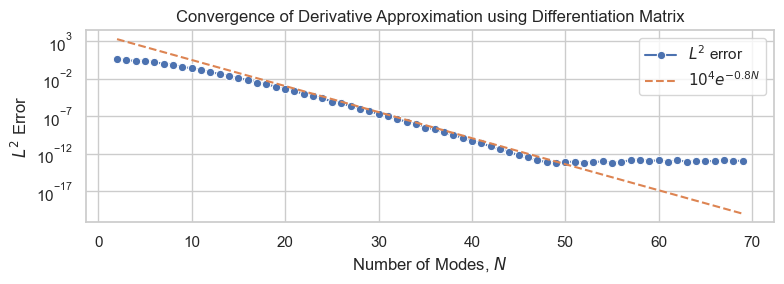

In [26]:
Ns = np.arange(2, 70, dtype=int)
convergence_data = []
for N_nodes in Ns:
    P_nodes = N_nodes - 1
    assert N_nodes > 1

    x_nodes = JacobiGL(alpha, beta, P_nodes)

    # Modal basis functions
    V = jacobi_p(x_nodes, alpha, beta, P_nodes)

    # Derivatives of modal basis functions at nodes
    V_x = grad_jacobi_p(x_nodes, alpha, beta, P_nodes)

    diff_matrix = V_x @ np.linalg.inv(V)

    # Now get nodes and evaluate
    v_nodal = v(x_nodes)

    # Evaluate derivative using differentiation matrix
    dv_approx_nodal = diff_matrix @ v_nodal
    dv_exact_nodal = dv_dx(x_nodes)

    # We need to also do integration to get error, which we again do using
    # Vandermonde through the mass matrix, which must be constructed using the
    # ortho_NORMAL_ polynomials
    V_orthonormal = jacobi_p_normalised(x_nodes, alpha, beta, P_nodes)
    M = np.linalg.inv(V_orthonormal @ V_orthonormal.T)
    errors_nodal = dv_exact_nodal - dv_approx_nodal

    error_l2 = np.sqrt(errors_nodal.T @ M @ errors_nodal)
    print(f"N={N_nodes}, L2 Error={error_l2}")

    convergence_data.append(
        {
            "N_nodes": N_nodes,
            "error_l2": error_l2,
        }
    )

df = pd.DataFrame(convergence_data)
plt.figure(figsize=(8, 3))
sns.lineplot(
    data=df, x="N_nodes", y="error_l2", marker="o", label="$L^2$ error"
)
plt.plot(
    Ns, 10000 * np.exp(-0.8 * Ns),
    label="$10^4 e^{-0.8 N}$",
    ls="--",
)
plt.semilogy()
plt.xlabel("Number of Modes, $N$")
plt.ylabel("$L^2$ Error")
plt.title("Convergence of Derivative Approximation using Differentiation Matrix")
plt.legend()
plt.tight_layout()

plt.savefig("report/output/2k_convergence.png", dpi=600, bbox_inches="tight")

### l - Mass Matrix

In [27]:
def u1(x):
    return np.ones_like(x, dtype=float)

def int_u1_sq(x, a, b):
    return b - a

def u2(x):
    return np.sin(x)

def int_u2_sq(x, a, b):
    indef = lambda x: x/2 - np.sin(2 * x) / 4
    return indef(b) - indef(a)

def xbar(x, a, b):
    return 0.5 * (b - a) * x + 0.5 * (a + b)

alpha = 0.0
beta = 0.0
N_nodes = 9
P_nodes = N_nodes - 1
a = 0
b = 2

x_nodes = JacobiGL(alpha, beta, P_nodes)
xbar_nodes = xbar(x_nodes, a, b)

V_orthonormal = jacobi_p_normalised(x_nodes, alpha, beta, P_nodes)
M = np.linalg.inv(V_orthonormal @ V_orthonormal.T)
M_transformed = (b - a) / 2 * M

u1_nodal = u1(xbar_nodes)
u1_norm_approx = np.sqrt(u1_nodal.T @ M_transformed @ u1_nodal)
u1_norm_exact = np.sqrt(int_u1_sq(xbar_nodes, a, b))
u1_error = np.abs(u1_norm_approx - u1_norm_exact)
print(f"U1 approx: {u1_norm_approx}, U1 exact: {u1_norm_exact}, U1 error: {u1_error}")

u2_nodal = u2(xbar_nodes)
u2_norm_approx = np.sqrt(u2_nodal.T @ M_transformed @ u2_nodal)
u2_norm_exact = np.sqrt(int_u2_sq(xbar_nodes, a, b))
u2_error = np.abs(u2_norm_approx - u2_norm_exact)
print(f"U2 approx: {u2_norm_approx}, U2 exact: {u2_norm_exact}, U2 error: {u2_error}")


U1 approx: 1.4142135623730951, U1 exact: 1.4142135623730951, U1 error: 0.0
U2 approx: 1.0905047564440025, U2 exact: 1.0905047564439974, U2 error: 5.10702591327572e-15
